In [1]:
from pickle import load, dump
import numpy as np
import string
import seaborn as sns
import os
import keras
from preprocess import *

Using TensorFlow backend.


In [2]:
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [3]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    word_count_threshold = 5
    word_counts = {}
    nsents = 0
    for sent in descriptions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if (word_counts[w] >= word_count_threshold)]
    print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))
    #print(word_counts)
    return vocab

In [4]:
def mapping(vocab):
    ixtoword = {}
    wordtoix = {}
    ix = 1
    for w in vocab:
        wordtoix[w] = ix
        ixtoword[ix] = w
        ix += 1
    return ixtoword, wordtoix

In [5]:
# summarize vocabulary
vocabulary = to_vocabulary(to_lines(train_descriptions))
print('Vocabulary Size: %d' % len(vocabulary))
ixtoword, wordtoix = mapping(vocabulary)

preprocessed words 7578 -> 2530
Vocabulary Size: 2530


In [6]:
dump(wordtoix, open('wordtoix.pkl', 'wb'))
dump(ixtoword, open('ixtoword.pkl', 'wb'))

In [7]:
vocab_size = len(vocabulary) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 2531


In [8]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return [len(d.split()) for d in lines]

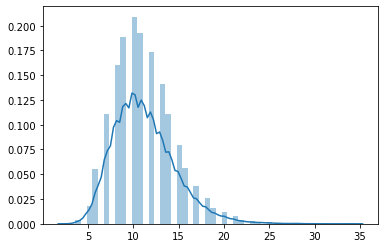

In [9]:
# determine the maximum sequence length
sns.distplot(max_length(train_descriptions))

In [10]:
max_len=15
print('Description Length: %d' % max_len)

Description Length: 15


In [11]:
# dev dataset
 
# load test set
filename = 'Flickr_8k.devImages.txt'
dev = load_set(filename)
print('Dataset: %d' % len(dev))
# descriptions
dev_descriptions = load_clean_descriptions('descriptions.txt', dev)
print('Descriptions: test=%d' % len(dev_descriptions))
# photo features
dev_features = load_photo_features('features.pkl', dev)
print('Photos: test=%d' % len(dev_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [12]:
# Load Glove vectors
glove_dir = 'C:\\Users\\PARAKH\\Desktop\\New folder\\glove.6B\\'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [14]:
embedding_matrix.shape

(2531, 200)

In [15]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = np.array(keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0])
                    # encode output sequence
                    out_seq = np.array(keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0])
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                X1=np.array(X1).reshape(-1,1000)
                X2=np.array(X2)
                y=np.array(y)
                yield [[X1, X2], y]
                X1, X2, y = list(), list(), list()
                n=0

In [16]:
# prepare sequence
train_generator= data_generator(train_descriptions,train_features, wordtoix, max_len,32)
 

In [17]:
dev_generator= data_generator(dev_descriptions,dev_features, wordtoix, max_len,32)

In [18]:
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = keras.layers.Input(shape=(4096,))
    fe1 = keras.layers.Dropout(0.5)(inputs1)
    fe2 = keras.layers.Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = keras.layers.Input(shape=(max_len,))
    se1 = keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim,input_length = max_len,weights = [embedding_matrix],trainable = False)(inputs2)
    se2 = keras.layers.Dropout(0.5)(se1)
    se3 = keras.layers.LSTM(256)(se2)
    # decoder model
    decoder1 = keras.layers.add([fe2, se3])
    decoder2 = keras.layers.Dense(256, activation='relu')(decoder1)
    outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [19]:
model = define_model(vocab_size, max_len)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 200)      506200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [20]:
steps = len(train_descriptions)//4

In [21]:
history = model.fit(train_generator, epochs=10, steps_per_epoch=steps,validation_data=dev_generator, validation_steps=steps, verbose=1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
1500/1500 [==============================] - 1136s 757ms/step - loss: 3.9086 - val_loss: 3.3483
Epoch 2/10
1500/1500 [==============================] - 1008s 672ms/step - loss: 3.1569 - val_loss: 3.2283
Epoch 3/10
1500/1500 [==============================] - 1008s 672ms/step - loss: 2.8904 - val_loss: 3.2872
Epoch 4/10
1500/1500 [==============================] - 1012s 674ms/step - loss: 2.7125 - val_loss: 3.3663
Epoch 5/10
1500/1500 [==============================] - 1009s 672ms/step - loss: 2.5825 - val_loss: 3.4373


In [22]:
#Saving Model
model.save('model.h5')